In [1]:
import xarray as xr
import aostools.climate as aos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [2]:
# variables = ['u', 'v', 't']
# files = []

# for var in variables:
#     blah = glob.glob(f'/gws/nopw/j04/arctic_connect/xum/ECMWF/ERA5/Daily/{var}/*.nc')
    
#     for element in blah:
#         files.append(element)
        
# print(len(files))

# # ds = xr.open_mfdataset(files, parallel=True, chunks={'time': 5397}) # chunks separates into 3 groups of 5397

# ds = xr.open_mfdataset(files, parallel=True, chunks={'longitude': 45})
# ds.attrs = {}  # for brevity, hide attributes
# ds = ds.drop_vars('time_bnds')
# ds

In [3]:
# ds = xr.open_dataset('/gws/nopw/j04/arctic_connect/cturrell/era5_data/era5daily_uvt.nc', parallel=True)
# ds

# import datetime as dt

# ds = ds.sel(time=ds.time.dt.month.isin([12,1,2]))
# ds

# ds.to_netcdf('/gws/nopw/j04/arctic_connect/cturrell/era5_data/era5daily_djf_uvt.nc')

In [4]:
# # Solve EP flux
# ep1, ep2, div1, div2 = aos.ComputeEPfluxDivXr(ds.u, ds.v, ds.t, 
#                                               lon='longitude', lat='latitude', pres='level', time='time', do_ubar=True)

# ds['ep1'] = (ep1.dims, ep1.values)
# ds['ep2'] = (ep2.dims, ep2.values)
# ds['div1'] = (div1.dims, div1.values)
# ds['div2'] = (div2.dims, div2.values)
# ds['ubar'] = (ubar.dims, ubar.values)
# ds

In [5]:
ds = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/era5_data/era5daily_djf_epfluxes.nc', 
                       parallel=True, chunks={'time': 31})

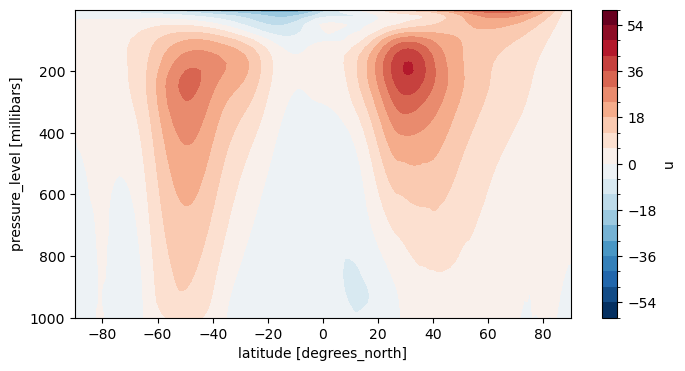

In [6]:
# compute zonal mean zonal wind
ubar = ds.u.mean(('time','longitude'))

ubar.plot.contourf(levels=20, yincrease=False, yscale='linear', figsize=(8,4))

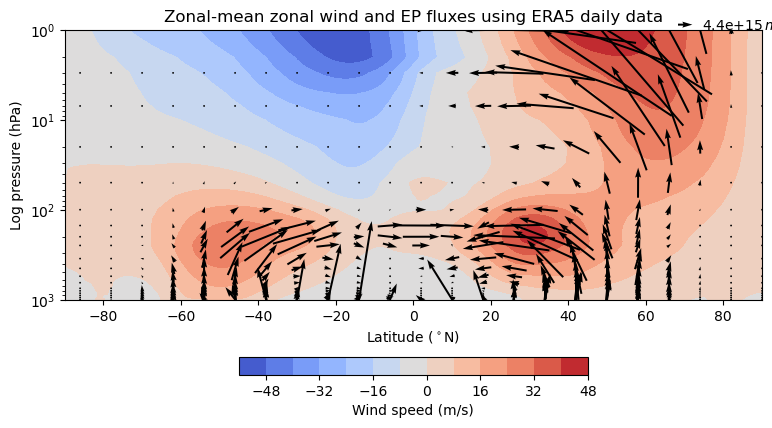

In [7]:
# skip variables
skip_lat = 8
skip_pres = 2

skip = dict( latitude=slice(None, None, skip_lat), level=slice(None, None, skip_pres) )

# set variables
lat = ds.latitude.isel(dict(latitude=slice(None, None, skip_lat)))
p = ds.level.isel(dict(level=slice(None, None, skip_pres)))
Fphi = ds.ep1.mean(('time')).isel(skip)
Fp = ds.ep2.mean(('time')).isel(skip)

fig, ax = plt.subplots(figsize=(9,5))

coolwarm = sns.color_palette("coolwarm", as_cmap=True)
RB = sns.color_palette('RdBu_r', as_cmap=True)

plt.contourf(ds.latitude.values, ds.level.values, ubar,
              cmap=coolwarm, levels=15)
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.5,
             label='Wind speed (m/s)')

aos.PlotEPfluxArrows(lat, p, Fphi, Fp,
                     fig, ax, pivot='mid', yscale='log')
plt.title('Zonal-mean zonal wind and EP fluxes using ERA5 daily data')
plt.xlabel('Latitude ($^\\circ$N)')
plt.ylabel('Log pressure (hPa)')
plt.show()

In [8]:
rename = {'latitude': 'lat', 'longitude':'lon'}
ds

<xarray.Dataset>
Dimensions:    (time: 4030, longitude: 360, latitude: 181, level: 37)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2023-02-28T09:00:00
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 360), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 360), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(31, 37, 181, 360), meta=np.ndarray>
    ep1        (time, level, latitude) float64 dask.array<chunksize=(31, 37, 181), meta=np.ndarray>
    ep2        (time, level, latitude) float64 dask.array<chunksize=(31, 37, 181), meta=np.ndarray>
    div1       (time, level, latitude) float64 dask.array<chunksize=(31, 37, 181), meta=np.ndarray>
    div2       (time, level, latitude) float64 dask.array<chunksize=(31, 37, 181), meta=np.ndarray>
    ubar       (level, latitude) float32 dask.array<chunksize=(37, 181), meta=np.ndarray>

## Diagnosing Issues

### Look at 1000hPa

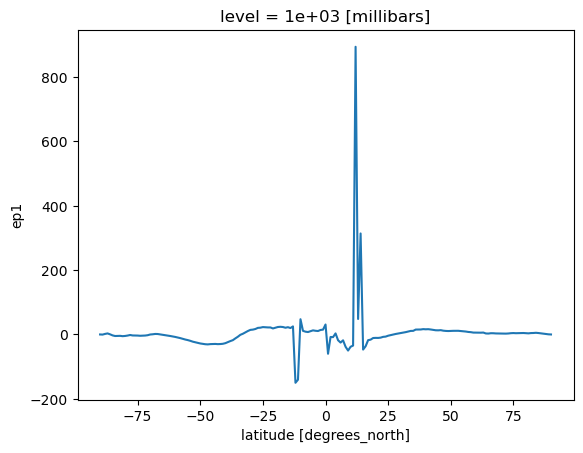

In [9]:
ds1 = ds.sel(level=1000.)
ds1.ep1.mean(('time')).plot.line()

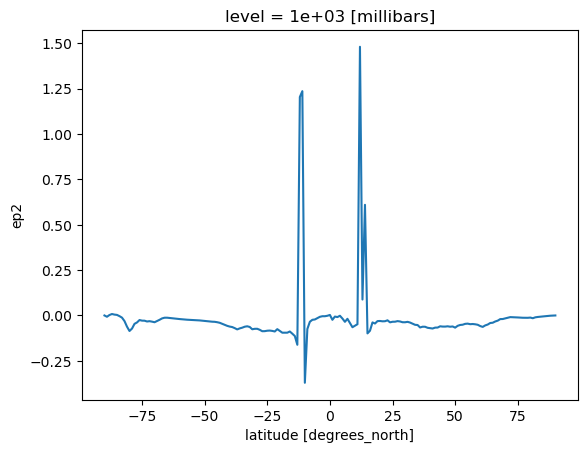

In [10]:
ds1.ep2.mean(('time')).plot.line()

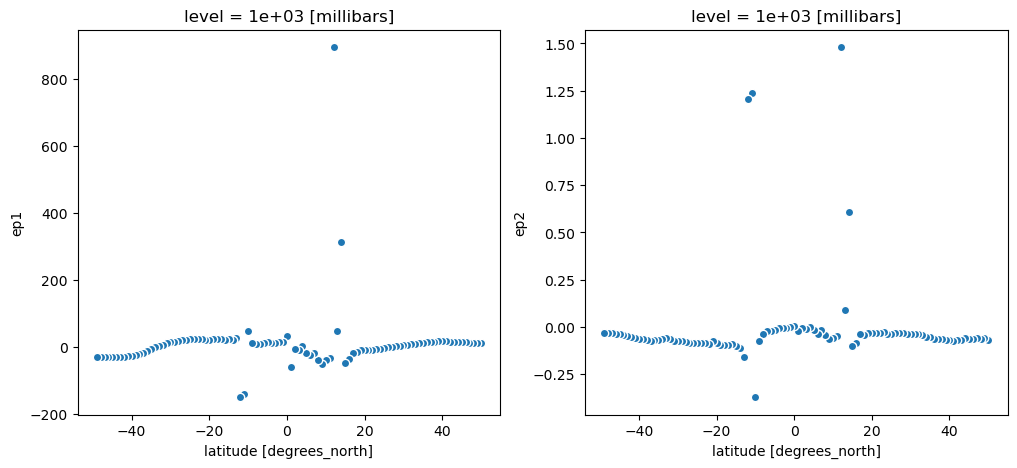

In [12]:
ds2 = ds1.isel(latitude=slice(40, 140))
ds2.latitude

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ds2.ep1.mean(('time')).plot.scatter(ax=ax1)
ds2.ep2.mean(('time')).plot.scatter(ax=ax2)
plt.show()

In [54]:
ds2.ep1.mean(('time')).values

array([ 1.08205951e+01,  1.06464838e+01,  1.09864216e+01,  1.17733716e+01,
        1.33780128e+01,  1.28386396e+01,  1.30112927e+01,  1.43604850e+01,
        1.54425874e+01,  1.64172003e+01,  1.60524925e+01,  1.65710265e+01,
        1.54469989e+01,  1.53939332e+01,  1.52067238e+01,  1.12245403e+01,
        1.10135778e+01,  9.11203365e+00,  7.23769367e+00,  5.85234385e+00,
        4.75398792e+00,  3.17594153e+00,  1.52019571e+00, -1.76973377e-01,
       -1.72741331e+00, -3.86231605e+00, -6.66852726e+00, -7.40979768e+00,
       -9.85749044e+00, -1.07817197e+01, -1.06106588e+01, -1.10477455e+01,
       -1.61102200e+01, -1.77370397e+01, -3.66511257e+01, -4.69775579e+01,
        3.13849579e+02,  4.80834352e+01,  8.93900669e+02, -3.44996251e+01,
       -3.82946146e+01, -5.00118697e+01, -3.81986024e+01, -1.82157815e+01,
       -2.51548231e+01, -1.79259657e+01,  3.28594040e+00, -8.28073880e+00,
       -7.87306030e+00, -5.99569254e+01,  3.09315034e+01,  1.49836569e+01,
        1.39552021e+01,  

In [76]:
ds2.ep2.mean(('time')).values

array([-0.06703537, -0.0606245 , -0.06197734, -0.05970147, -0.06133895,
       -0.06125361, -0.05967664, -0.06666912, -0.06698369, -0.07189642,
       -0.07017547, -0.06792514, -0.06224507, -0.06198597, -0.06621882,
       -0.05262776, -0.05148217, -0.04496213, -0.03905356, -0.03514831,
       -0.0374824 , -0.03731961, -0.03311076, -0.03114827, -0.03440041,
       -0.03466731, -0.03790124, -0.02671271, -0.03171156, -0.03221121,
       -0.03037718, -0.03108694, -0.04440658, -0.03829952, -0.08416823,
       -0.09881646,  0.60963217,  0.0877888 ,  1.48025422, -0.04824136,
       -0.05618255, -0.06477439, -0.04148452, -0.01841644, -0.03508212,
       -0.01695751, -0.00164145, -0.0088969 , -0.00606334, -0.02392655,
        0.00283232, -0.00167264, -0.00424373, -0.00418443, -0.00738649,
       -0.01486441, -0.02205601, -0.02394213, -0.03471343, -0.07443204,
       -0.37087906,  1.23578387,  1.20348098, -0.16143874, -0.11337854,
       -0.10037143, -0.08829701, -0.09484686, -0.0949469 , -0.09

### Find latitudes of Outliers

In [73]:
ds3 = ds2.ep1.mean(('time'))
ds3 = ds3.where(abs(ds3) > 100)
ds3.values

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
        313.84957887,           nan,  893.90066891,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

In [74]:
# find latitudes of outliers for EP1
where = np.where(abs(ds3) > 100)
ds3.latitude[where]

<xarray.DataArray 'latitude' (latitude: 4)>
array([ 14.,  12., -11., -12.], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 14.0 12.0 -11.0 -12.0
    level     float64 1e+03
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [77]:
# find latitudes of outliers for EP2
where2 = np.where(abs(ds2.ep2.mean(('time'))) > 0.25)
ds2.latitude[where2]

<xarray.DataArray 'latitude' (latitude: 5)>
array([ 14.,  12., -10., -11., -12.], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 14.0 12.0 -10.0 -11.0 -12.0
    level     float64 1e+03
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

### Remove outliers

-10.610658770055515


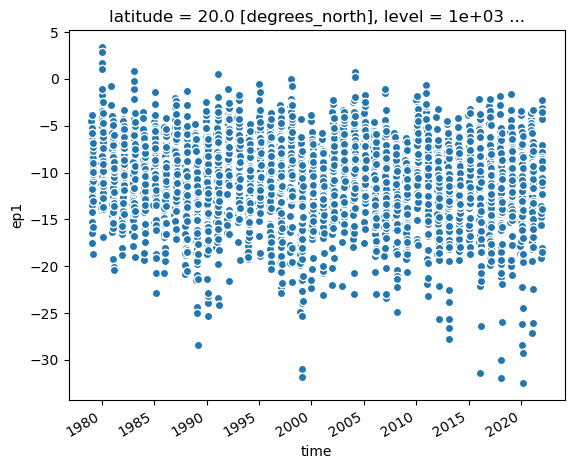

In [55]:
# an example of what we would expect to see...
ds20 = ds1.sel(latitude=20.)

print(ds20.ep1.mean(('time')).values)
ds20.ep1.plot.scatter()

313.8495788738576


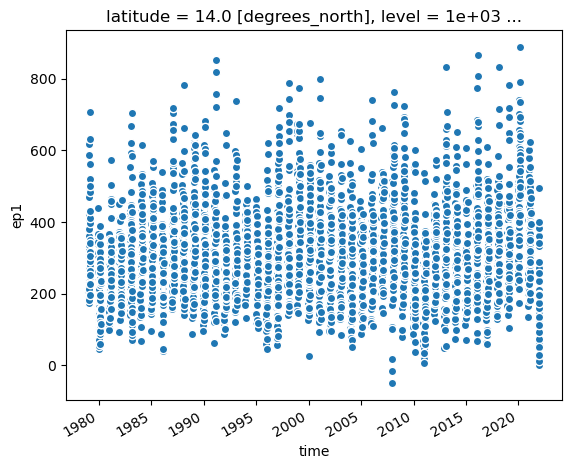

In [53]:
ds14 = ds1.sel(latitude=14.)

print(ds14.ep1.mean(('time')).values)
ds14.ep1.plot.scatter()

893.9006689126622


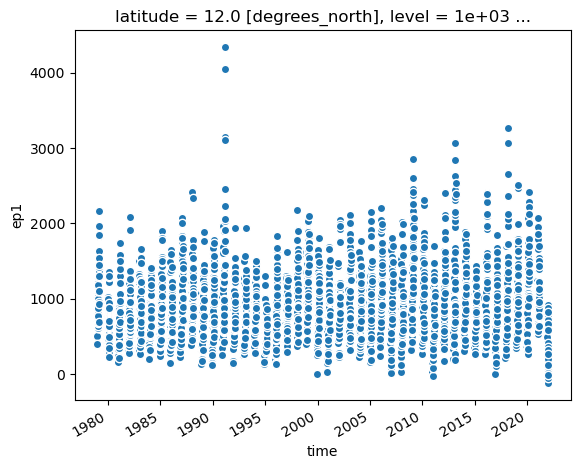

In [56]:
ds12 = ds1.sel(latitude=12.)

print(ds12.ep1.mean(('time')).values)
ds12.ep1.plot.scatter()

-150.1300920938591


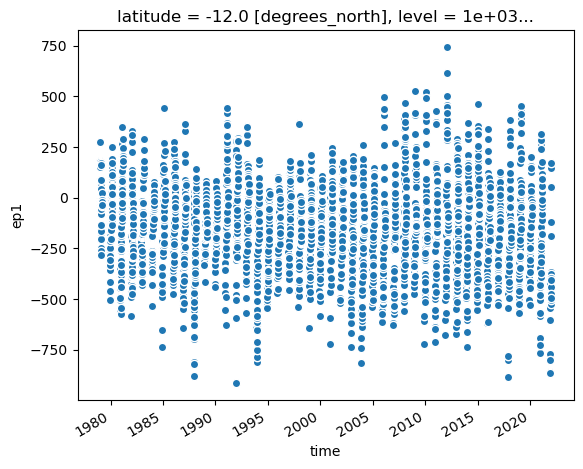

In [57]:
# latitude = -12
ds_12 = ds1.sel(latitude=-12.)

print(ds_12.ep1.mean(('time')).values)
ds_12.ep1.plot.scatter()

-140.60370856158795


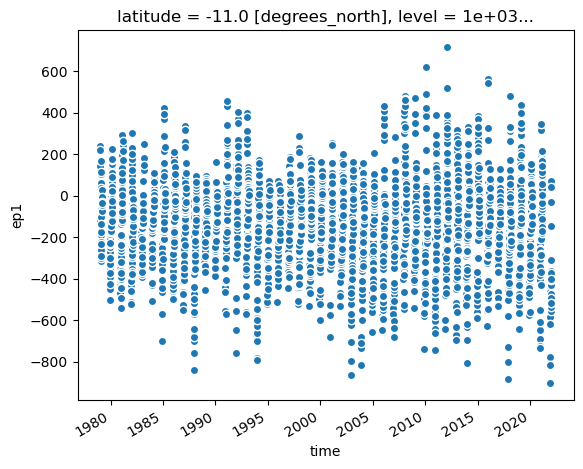

In [58]:
# latitude = -12
ds_11 = ds1.sel(latitude=-11.)

print(ds_11.ep1.mean(('time')).values)
ds_11.ep1.plot.scatter()

They seem to be extremely large in general, not just the mean. Will now attempt to replace the values in the time averaged data.

## Handling the Outliers

In [86]:
ds1.ep1.mean(('time')).values

array([ 0.00000000e+00,  4.43614426e-01,  1.49422376e+00,  2.60278316e+00,
        3.59554481e+00,  4.45553099e+00,  5.20204891e+00,  4.58335169e+00,
        4.32788396e+00,  3.45200452e+00,  3.83233538e+00,  4.52273552e+00,
        4.21692593e+00,  3.95962722e+00,  3.90121546e+00,  4.36057996e+00,
        3.96879084e+00,  3.07437133e+00,  2.62992683e+00,  2.74596800e+00,
        2.72512264e+00,  3.17301854e+00,  3.19100432e+00,  3.78243607e+00,
        3.87893290e+00,  2.80076264e+00,  3.11481421e+00,  5.87777435e+00,
        5.54057557e+00,  5.62223014e+00,  5.44698973e+00,  5.84617039e+00,
        7.15473703e+00,  7.80068890e+00,  9.06940269e+00,  9.87232980e+00,
        1.07338429e+01,  1.13975286e+01,  1.14830144e+01,  1.13088937e+01,
        1.08205951e+01,  1.06464838e+01,  1.09864216e+01,  1.17733716e+01,
        1.33780128e+01,  1.28386396e+01,  1.30112927e+01,  1.43604850e+01,
        1.54425874e+01,  1.64172003e+01,  1.60524925e+01,  1.65710265e+01,
        1.54469989e+01,  

In [89]:
remove = ds1.ep1.mean(('time')).where(abs(ds1.ep1.mean(('time'))) < 100.)
remove

array([  0.        ,   0.44361443,   1.49422376,   2.60278316,
         3.59554481,   4.45553099,   5.20204891,   4.58335169,
         4.32788396,   3.45200452,   3.83233538,   4.52273552,
         4.21692593,   3.95962722,   3.90121546,   4.36057996,
         3.96879084,   3.07437133,   2.62992683,   2.745968  ,
         2.72512264,   3.17301854,   3.19100432,   3.78243607,
         3.8789329 ,   2.80076264,   3.11481421,   5.87777435,
         5.54057557,   5.62223014,   5.44698973,   5.84617039,
         7.15473703,   7.8006889 ,   9.06940269,   9.8723298 ,
        10.73384285,  11.39752859,  11.48301439,  11.3088937 ,
        10.82059507,  10.64648384,  10.98642162,  11.7733716 ,
        13.37801284,  12.83863964,  13.01129273,  14.36048502,
        15.4425874 ,  16.41720029,  16.05249245,  16.57102647,
        15.44699887,  15.39393323,  15.20672381,  11.2245403 ,
        11.01357785,   9.11203365,   7.23769367,   5.85234385,
         4.75398792,   3.17594153,   1.52019571,  -0.17

In [107]:
ep1 = ds.ep1.mean(('time'))
ep2 = ds.ep2.mean(('time'))

ep1[-1,:]

<xarray.DataArray 'ep1' (latitude: 181)>
dask.array<getitem, shape=(181,), dtype=float64, chunksize=(181,), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
    level     float64 1e+03

In [115]:
ep1_1000hPa = ep1.sel(level=1000.).where(abs(ep1.sel(level=1000.)) < 100).values

ep1[-1,:] = ep1_1000hPa
ep1.sel(level=1000.).values

array([  0.        ,   0.44361443,   1.49422376,   2.60278316,
         3.59554481,   4.45553099,   5.20204891,   4.58335169,
         4.32788396,   3.45200452,   3.83233538,   4.52273552,
         4.21692593,   3.95962722,   3.90121546,   4.36057996,
         3.96879084,   3.07437133,   2.62992683,   2.745968  ,
         2.72512264,   3.17301854,   3.19100432,   3.78243607,
         3.8789329 ,   2.80076264,   3.11481421,   5.87777435,
         5.54057557,   5.62223014,   5.44698973,   5.84617039,
         7.15473703,   7.8006889 ,   9.06940269,   9.8723298 ,
        10.73384285,  11.39752859,  11.48301439,  11.3088937 ,
        10.82059507,  10.64648384,  10.98642162,  11.7733716 ,
        13.37801284,  12.83863964,  13.01129273,  14.36048502,
        15.4425874 ,  16.41720029,  16.05249245,  16.57102647,
        15.44699887,  15.39393323,  15.20672381,  11.2245403 ,
        11.01357785,   9.11203365,   7.23769367,   5.85234385,
         4.75398792,   3.17594153,   1.52019571,  -0.17

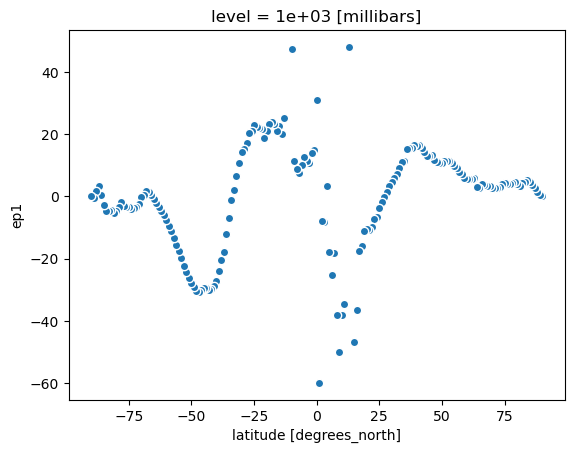

In [116]:
ep1.sel(level=1000.).plot.scatter()

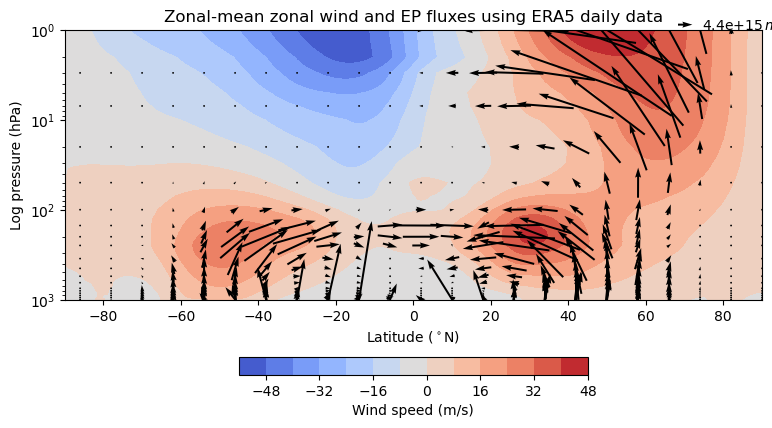

In [117]:
# skip variables
skip_lat = 8
skip_pres = 2

skip = dict( latitude=slice(None, None, skip_lat), level=slice(None, None, skip_pres) )

# set variables
lat = ds.latitude.isel(dict(latitude=slice(None, None, skip_lat)))
p = ds.level.isel(dict(level=slice(None, None, skip_pres)))
Fphi = ep1.isel(skip)
Fp = ep2.isel(skip)

fig, ax = plt.subplots(figsize=(9,5))

coolwarm = sns.color_palette("coolwarm", as_cmap=True)
RB = sns.color_palette('RdBu_r', as_cmap=True)

plt.contourf(ds.latitude.values, ds.level.values, ubar,
              cmap=coolwarm, levels=15)
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.5,
             label='Wind speed (m/s)')

aos.PlotEPfluxArrows(lat, p, Fphi, Fp,
                     fig, ax, pivot='mid', yscale='log')
plt.title('Zonal-mean zonal wind and EP fluxes using ERA5 daily data')
plt.xlabel('Latitude ($^\\circ$N)')
plt.ylabel('Log pressure (hPa)')
plt.show()